In [1]:
# default_exp gen_cb

Contains utilities for generating calibration board images

# Import 

In [2]:
#export
import copy

import descartes
import matplotlib.pyplot as plt
import numpy as np
import skimage.draw
import skimage.filters
import skimage.transform
from IPython.core.debugger import set_trace
from shapely import affinity
from shapely.geometry import Point, Polygon

# Utility

In [3]:
#export
def meshgrid2ps(r_x, r_y, order='C'):
    xs, ys = np.meshgrid(r_x, r_y)
    return np.c_[xs.ravel(order), ys.ravel(order)]

In [4]:
#export 
def _xform_ps(ps, mat):
    ps, mat = map(np.array, [ps,mat])
    ps_aug = np.concatenate([ps, np.ones((ps.shape[0], 1))], axis=1)
    return (mat@ps_aug.T).T

In [5]:
#export 
def affine_ps(ps, mat):
    # Assumes last row of mat is [0, 0, 1]
    return _xform_ps(ps, mat)[:, 0:2]

In [6]:
#export 
def homography_ps(ps, mat):
    ps = _xform_ps(ps, mat)
    return ps[:, 0:2]/ps[:, 2:]

In [7]:
#export 
def rotate_ps(ps, deg):
    theta = np.radians(deg)
    R = [[np.cos(theta), -np.sin(theta), 0],
         [np.sin(theta),  np.cos(theta), 0],
         [            0,              0, 1]]    
    return affine_ps(ps, R)

In [8]:
#export
def get_circle_poly(p, r):
     return Point(p).buffer(r)

In [9]:
#export
def rotate_poly(poly, deg):
    return affinity.rotate(poly, deg, origin=(0,0))

In [10]:
#export
def affine_poly(poly, mat):
    mat = np.array(mat)
    return affinity.affine_transform(poly, np.r_[mat[0:2,0:2].ravel(), mat[0,2], mat[1,2]])

In [11]:
#export
def poly2coords(poly):
    if isinstance(poly, Polygon):
        poly = [poly]
        
    coords = []
    for idx, p in enumerate(poly):
        coord = {}
        coord['ext'] = np.array(p.exterior.coords)
        coord['int'] = []
        for i in p.interiors:
            coord['int'].append(np.array(i.coords))
        coords.append(coord)
        
    return coords

In [12]:
#export
def _xform_coords(coords, mat, f_ps):
    coords = copy.deepcopy(coords)
    for coord in coords:
        coord['ext'] = f_ps(coord['ext'], mat)
        for idx in range(len(coord['int'])):
            coord['int'][idx] = f_ps(coord['int'][idx], mat)
    return coords            

In [13]:
#export
def affine_coords(coords, mat):
    return _xform_coords(coords, mat, affine_ps)   

In [14]:
#export
def homography_coords(coords, mat):
    return _xform_coords(coords, mat, homography_ps)   

In [15]:
#export
def plot_coords(coords):
    plt.figure(figsize=(10,10))
    for coord in coords:
        plt.scatter(coord['ext'][:,0], coord['ext'][:,1], c='g')
        for ps_int in coord['int']:
            plt.scatter(ps_int[:,0], ps_int[:,1], c='r')
        
    plt.axis('equal')

In [16]:
#export
def euler2R(euler):
    theta_x, theta_y, theta_z = euler

    R_x = [[1,               0,                0],
           [0, np.cos(theta_x), -np.sin(theta_x)],
           [0, np.sin(theta_x),  np.cos(theta_x)]]
    
    R_y = [[ np.cos(theta_y), 0, np.sin(theta_y)],
           [               0, 1,               0],
           [-np.sin(theta_y), 0, np.cos(theta_y)]]
    
    R_z = [[np.cos(theta_z), -np.sin(theta_z), 0],
           [np.sin(theta_z),  np.cos(theta_z), 0],
           [              0,                0, 1]];

    R_x, R_y, R_z = map(np.array, [R_x, R_y, R_z])
    return R_z@R_y@R_x

In [17]:
#export
def ARt2H(A, R, t):
    A, R, t = map(np.array,[A, R, t])
    return A@np.c_[R[:,0:2], t]

In [18]:
#export 
def get_bb(ps):
    return np.array([[ps[:,0].min(), ps[:,1].min()],
                     [ps[:,0].max(), ps[:,1].max()]])

# Fiducal Marker Polygons

In [19]:
#export
def get_fiducial_poly(num):
    # Returns fiducial marker normalized and centered around (0, 0)
    deg_pad = 46.1564
    
    # Get "outer" and "center" base polygons
    poly_o = get_circle_poly((0,0), 0.5).difference(get_circle_poly((0,0), 1/3))
    poly_c = get_circle_poly((0,0), 1/6)
    
    def _triangle(deg=0):
        p1 = np.array([[0, 0]])
        p2 = rotate_ps([[0, 1]], -deg_pad/2)
        p3 = rotate_ps([[0, 1]],  deg_pad/2)
        return rotate_poly(Polygon(np.concatenate([p1, p2, p3])), deg)
    
    def _circles(deg=0):
        poly_c1 = get_circle_poly(rotate_ps([[0, 5/12]], -deg_pad/2).ravel(), 1/12)
        poly_c2 = get_circle_poly(rotate_ps([[0, 5/12]],  deg_pad/2).ravel(), 1/12)
        return rotate_poly(poly_c1, deg), rotate_poly(poly_c2, deg)
    
    def _split(poly_o, deg):
        poly_t = _triangle(deg)
        poly_c1, poly_c2 = _circles(deg)
        return (poly_o.difference(poly_t)
                      .union(poly_c1)
                      .union(poly_c2))
                
    # Modify based on marker num
    if num == 1:
        pass # First marker has no splits
    elif 2 <= num <= 4:
        for deg in np.linspace(0, 360, num+1)[:-1]:
            poly_o = _split(poly_o, deg)
    else:
        raise RuntimeError(f'Invalid fiducial marker number: {num}')
    
    # Return polygon
    return poly_o.union(poly_c) # NOTE: I *think* this ordering may matter for drawing

### Test

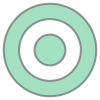

In [20]:
get_fiducial_poly(num=1)

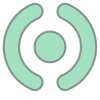

In [21]:
get_fiducial_poly(num=2)

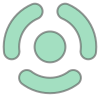

In [22]:
get_fiducial_poly(num=3)

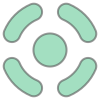

In [23]:
get_fiducial_poly(num=4)

# Target polygons

In [24]:
#export
def get_checker_poly(i, j):
    # Returns checker target normalized and centered around (0, 0)
    poly_s1 = Polygon([[-.5, 0.5], [0.0, 0.5], [0.0, 0.0], [-.5, 0.0]])
    poly_s2 = Polygon([[0.0, 0.0], [0.5, 0.0], [0.5, -.5], [0.0, -.5]])
    poly = poly_s1.union(poly_s2)
    if np.mod(i+j, 2) == 1:
        poly = rotate_poly(poly, 90)
    return poly

### Test

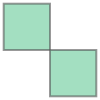

In [25]:
get_checker_poly(0,0)

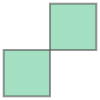

In [26]:
get_checker_poly(1,0)

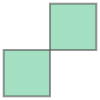

In [27]:
get_checker_poly(0,1)

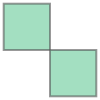

In [28]:
get_checker_poly(1,1)

# Calibration board polygon

In [29]:
#export
def get_ps_b(opts):    
    h_cb, w_cb = opts['height_cb'], opts['width_cb']
    return meshgrid2ps([-w_cb/2, w_cb/2], [-h_cb/2, h_cb/2], 'F')

In [30]:
#export
def get_ps_fp(opts):
    h_fp, w_fp = opts['height_fp'], opts['width_fp']; 
    return meshgrid2ps([-w_fp/2, w_fp/2], [-h_fp/2, h_fp/2], 'F')

In [31]:
#export
def get_ps_t(opts):
    s_t, num_t_w, num_t_h = opts['spacing_target'], opts['num_targets_width'], opts['num_targets_height']
    w_t, h_t = s_t*(num_t_w-1), s_t*(num_t_h-1)
    return meshgrid2ps(np.linspace(-w_t/2,  w_t/2, num_t_w), np.linspace( h_t/2, -h_t/2, num_t_h))

In [32]:
#export
def get_poly_cb(f_fiducial_poly, f_target_poly, opts):
    # Get board
    ps_b = get_ps_b(opts)
    poly_cb = Polygon(ps_b[[0,2,3,1], :])
    
    # Subtract fiducial markers
    s_f = opts['size_fiducial']
    ps_fp = get_ps_fp(opts)
    for idx, p_fp in enumerate(ps_fp):
        fiducial_poly = f_fiducial_poly(idx+1)
        poly_cb = poly_cb.difference(affine_poly(fiducial_poly, [[s_f,   0, p_fp[0]],
                                                                 [  0, s_f, p_fp[1]],
                                                                 [  0,   0,      1]]))

    # Subtract targets
    sz_t, num_t_w, num_t_h = opts['size_target'], opts['num_targets_width'], opts['num_targets_height']
    ps_t = get_ps_t(opts)
    for idx, p_t in enumerate(ps_t):    
        target_poly = f_target_poly(*np.unravel_index(idx, (num_t_h, num_t_w)))
        poly_cb = poly_cb.difference(affine_poly(target_poly, [[sz_t,    0, p_t[0]],
                                                               [   0, sz_t, p_t[1]],
                                                               [   0,    0,     1]]))

    return poly_cb

In [33]:
#export
def plot_cb_poly(cb_poly, opts):
    w_cb, h_cb = opts['width_cb'], opts['height_cb']
    plt.figure(figsize=(10,10))
    plt.gca().add_patch(descartes.PolygonPatch(cb_poly))
    plt.gca().set_xlim((-w_cb/2, w_cb/2))
    plt.gca().set_ylim((-h_cb/2, h_cb/2))
    plt.gca().set_aspect(1)

### Test

In [34]:
# Checkerboard geometry
opts = {}
opts['height_cb']           = 50.8
opts['width_cb']            = 50.8
opts['num_targets_height']  = 16
opts['num_targets_width']   = 16
opts['spacing_target']      = 2.032
opts['height_fp']           = 42.672
opts['width_fp']            = 42.672
opts['size_fiducial']       = 2.5*opts['spacing_target']
opts['size_target']         = opts['spacing_target']

In [35]:
poly_cb = get_poly_cb(get_fiducial_poly, get_checker_poly, opts)

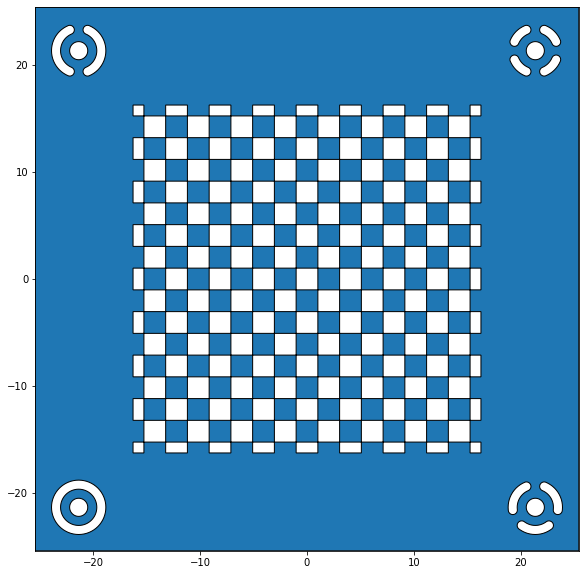

In [36]:
plot_cb_poly(poly_cb, opts)

# Drawing calibration board

In [37]:
#export
def draw_ps(ps, img, val):
    i, j = [], []
    if ps.shape[0] > 0:
        j, i = skimage.draw.polygon(ps[:, 0], ps[:, 1], img.T.shape)
    img[i, j] = val
    return img

In [38]:
#export
def draw_cb_coords(coords_cb, img):
    for coord in coords_cb:
        draw_ps(coord['ext'], img, 1)
        for ps_int in coord['int']:
            draw_ps(ps_int, img, 0)
    
    return img

### Test

In [39]:
# Checkerboard geometry
opts = {}
opts['height_cb']          = 50.8
opts['width_cb']           = 50.8
opts['num_targets_height'] = 16
opts['num_targets_width']  = 16
opts['spacing_target']     = 2.032
opts['height_fp']          = 42.672
opts['width_fp']           = 42.672
opts['size_fiducial']      = 2.5*opts['spacing_target']
opts['size_target']        = opts['spacing_target']

In [40]:
poly_cb = get_poly_cb(get_fiducial_poly, get_checker_poly, opts)

In [41]:
coords_cb = poly2coords(poly_cb)

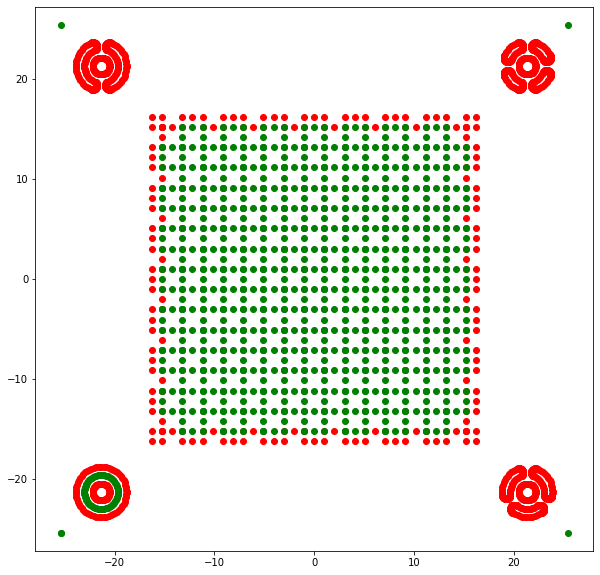

In [42]:
plot_coords(coords_cb)

In [43]:
sf = 20
padding = 400
h, w = sf*opts['height_cb']+2*padding, sf*opts['width_cb']+2*padding
x, y = w/2, h/2

In [44]:
coords_cb = (affine_coords(coords_cb, [[sf,  0,  x],
                                       [ 0, sf,  y],
                                       [ 0,  0,  1]]))

In [45]:
sz_img = (round(h), round(w))
img = np.random.normal(0, 1, size=sz_img)

In [46]:
img = draw_cb_coords(coords_cb, img)

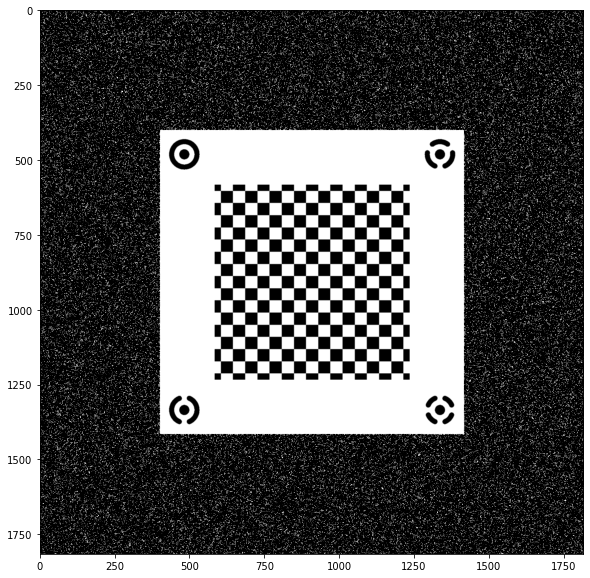

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1, cmap='gray', interpolation='bilinear')

# Create random calibration board and masks

In [48]:
# Checkerboard geometry
opts = {}
opts['height_cb']          = 50.8
opts['width_cb']           = 50.8
opts['num_targets_height'] = 16
opts['num_targets_width']  = 16
opts['spacing_target']     = 2.032
opts['height_fp']          = 42.672
opts['width_fp']           = 42.672
opts['size_fiducial']      = 2.5*opts['spacing_target']
opts['size_target']        = opts['spacing_target']

In [49]:
poly_cb = get_poly_cb(get_fiducial_poly, get_checker_poly, opts)
coords_cb_w = poly2coords(poly_cb)

In [50]:
h, w = 1536, 2048

In [51]:
x_o, y_o = (w-1)/2, (h-1)/2
alpha = 3650

In [52]:
A = [[alpha,     0,    x_o],
     [    0, alpha,    y_o],
     [    0,     0,      1]]

In [53]:
t_z = np.random.uniform(150, 300)
theta_t_x = np.random.uniform(-np.pi/64, np.pi/64)
theta_t_y = np.random.uniform(-np.pi/32, np.pi/32)

theta_x = np.random.uniform(-np.pi/4, np.pi/4)
theta_y = np.random.uniform(-np.pi/4, np.pi/4) 
theta_z = np.random.uniform(-np.pi, np.pi) 

In [54]:
t = euler2R([theta_t_x, theta_t_y, 0])@np.array([[0], [0], [t_z]])
R = euler2R([theta_x, theta_y, theta_z])
H = ARt2H(A,R,t)

In [55]:
coords_cb_p = homography_coords(coords_cb_w, H)
img = draw_cb_coords(coords_cb_p, np.zeros((h, w), dtype=np.float32))

In [56]:
ps_fp_w = get_ps_fp(opts)
ps_fp_p = homography_ps(ps_fp_w, H)
s_f = opts['size_fiducial']
bbs_f_p = []
mask_f = np.zeros((h, w), dtype=np.int)
for idx, p_fp_w in enumerate(ps_fp_w):
    ps_f_p = homography_ps(np.array(get_circle_poly(p_fp_w, s_f/2).exterior.coords), H)
    bbs_f_p.append(get_bb(ps_f_p))
    draw_ps(ps_f_p, mask_f, idx+1)

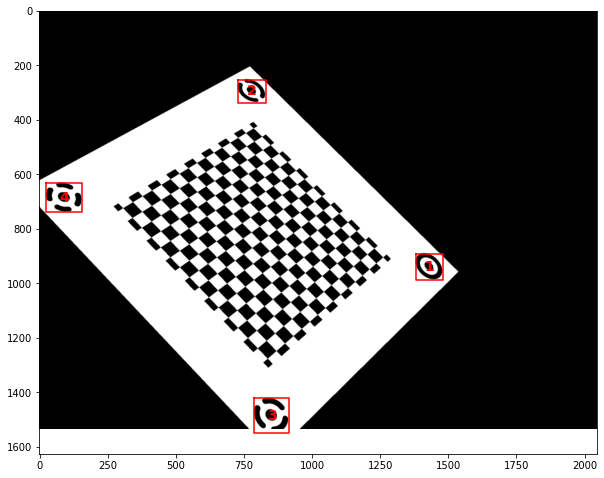

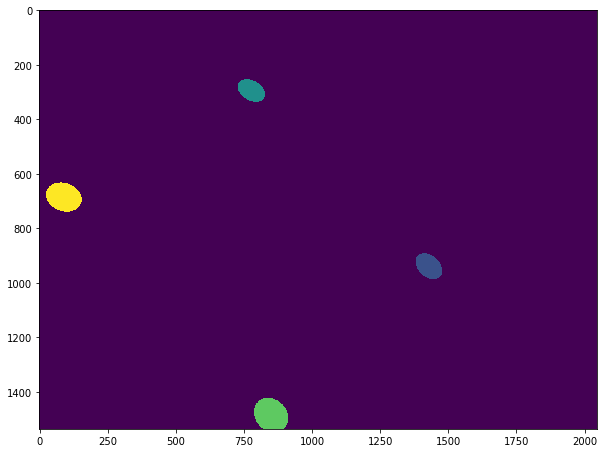

In [57]:
plt.figure(1, figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1, cmap='gray', interpolation='bilinear')
for idx, (p_fp_p, bb_f_p) in enumerate(zip(ps_fp_p, bbs_f_p)):
    plt.text(p_fp_p[0], p_fp_p[1], str(idx+1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=14, 
             weight='bold',
             color='red')
    plt.plot(bb_f_p[[0,0,1,1,0],0], bb_f_p[[0,1,1,0,0],1], 'r')
    
plt.figure(2, figsize=(10,10))
plt.imshow(mask_f)

# Build

In [58]:
!nbdev_build_lib

Converted data.ipynb.
Converted gen_cb.ipynb.
Converted models.ipynb.
Converted train.ipynb.
